# Reservoir Computing in Nengo

This notebook shows how reservoir computing can be formulated naturally within Nengo, with the additional benefit of having a principled way to build structure into the reservoir in both spiking (_Liquid State Machine_ (LSM)) and non-spiking (_Echo State Network_ (ESN)) cases. This allows us to understand how the reservoir is computing, improve simulation times by a factor $O(n)$, and improve performance on spiking hardware.

In [1]:
%pylab inline
import pylab
try:
    import seaborn as sns  # optional; prettier graphs
except ImportError:
    pass

import numpy as np
import nengo
from nengo.solvers import LstsqL2
from nengo.utils.numpy import rmse, rms

Populating the interactive namespace from numpy and matplotlib


c:\users\aaron\anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Structured Reservoirs

We revisit the `PadeDelay` network from `doc/notebooks/examples/linear_network.ipynb`, which approximated a pure delay of $\tau$ seconds using the transfer function $H(s) = e^{-\tau s}$. This is implemented below using $1000$ `LIF` neurons and a `Lowpass` synapse. The `radii` were set by inspecting the absolute values of `subnet.x.input` in response to a test stimulus.

We use this to delay an $8$ Hz band-limited white noise signal by $90$ ms. 

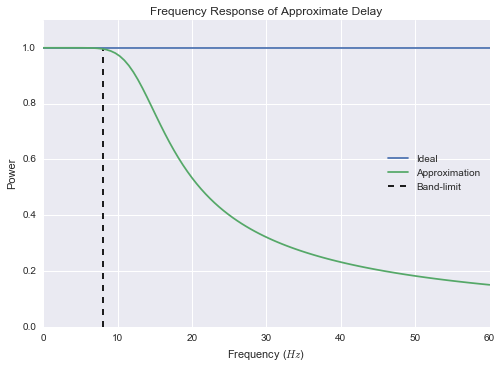

In [2]:
import nengolib
from nengolib.networks import Reservoir, EchoState, LinearNetwork
from nengolib.synapses import PadeDelay, PureDelay

n_neurons = 500
neuron_type = nengo.neurons.LIF()
synapse = 0.005
dt = 0.0005

delay = 0.09
function = lambda x: PureDelay(int(delay/dt)).filt(x, dt=dt)

train_t = 2.0
test_t = 2.0
process = nengo.processes.WhiteSignal(max(train_t, test_t), high=8, rms=0.3)

with nengolib.Network() as model:
    subnet = LinearNetwork(
        PadeDelay(4, 5, delay), n_neurons=n_neurons, synapse=synapse, input_synapse=None,
        radii=[0.1, 0.1, 0.16, 0.21, 0.35], dt=dt, neuron_type=neuron_type, seed=0,
        solver=LstsqL2(reg=1e-2))
    
    stim = nengo.Node(output=process)
    nengo.Connection(stim, subnet.input, synapse=None)
    
    output = nengo.Node(size_in=1)
    nengo.Connection(subnet.output, output, synapse=synapse)
    
    p_stim = nengo.Probe(stim, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
freqs = np.linspace(0, 60, 100)
pylab.figure()
pylab.title("Frequency Response of Approximate Delay")
pylab.plot(freqs, np.ones_like(freqs), label="Ideal")
pylab.plot(freqs, abs(subnet.sys.evaluate(freqs)), label="Approximation")
pylab.vlines([process.high], 0, 1, label="Band-limit", linestyle='--')
pylab.ylim(0, 1.1)
pylab.xlabel("Frequency ($Hz$)")
pylab.ylabel("Power")
pylab.legend(loc='center right')
pylab.show()

This uses Principle 3 from the NEF to map the desired dynamics onto a recurrently connected ensemble of neurons. But instead of using the readout that was solved for using Principle 2, we can place the ensemble in a `Reservoir`, and solve for the optimal linear readout from the neurons in the linear network's `EnsembleArray` that represents the state vector.

In [3]:
res = Reservoir(
    inputs=subnet.input, outputs=subnet.x.add_neuron_output(),
    network=subnet, readout_synapse=synapse)

We then train the reservoir on some realization of the random process (ignoring the first $180$ ms of data to allow the reservoir some time to initialize its state), which learns a linear readout to `res.output`. This new node is probed by simulating the network with a different random signal.

c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble "0">) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble "1">) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble "2">) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble "3">) should have its own seed to help ensure that its parameters do not change between training and tes

Simulation finished in 0:00:07.                                                 


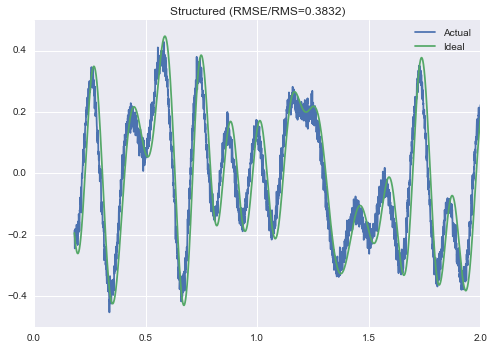

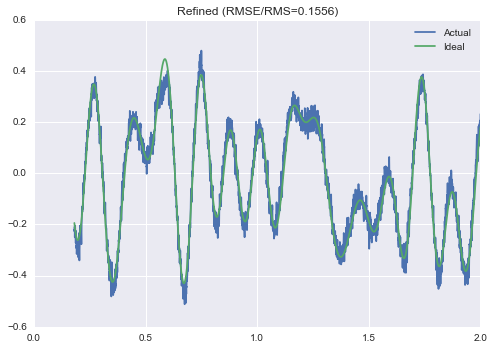

In [4]:
# Training
train_seed = 2
res.train(function, train_t, dt, process,
          t_init=2*delay, solver=LstsqL2(reg=0.1), seed=train_seed)

with model:
    p_refined = nengo.Probe(res.output, synapse=None)

# Validation
test_seed = 1
with nengo.Simulator(model, dt=dt, seed=test_seed) as sim:
    sim.run(test_t)

def plot_results(t, y, y_est, title):
    offset = int(2 * delay / dt)
    error = rmse(y[offset:], y_est[offset:]) / rms(y[offset:])

    pylab.figure()
    pylab.title("%s (RMSE/RMS=%.4f)" % (title, error))
    pylab.plot(t[offset:], y_est[offset:], label="Actual")
    pylab.plot(t[offset:], y[offset:], label="Ideal")
    pylab.legend()
    pylab.show()

plot_results(sim.trange(), function(sim.data[p_stim]), sim.data[p_output], title="Structured")
#plot_results(info['sim'].trange(), function(info['data_in']), np.dot(info['data_mid'], d), title="Refined - Training")
plot_results(sim.trange(), function(sim.data[p_stim]), sim.data[p_refined], title="Refined")

The first plot (structured) is the network built using standard Nengo / NEF theory, which does pretty well, but does not account for the temporal dynamics induced by the spiking `LIF` (note that changing the neuron type to `LIFRate` will give a nearly perfect match).

The second plot (refined) accounts for the neural dynamics by solving for the linear readout from the reservoir (which contains the ensemble representing the state of the system). This does much better at aligning the signal in time, because it has refined the readout to include the dynamics of the neurons, while also compensating for any approximation error in the state vector (in this example the latter source of error is relatively negligible [see the very first figure], but it may be more considerable for other systems).

This more holistic view of the optimization problem allows us to improve performance with the same amount of resources. We remark that these two networks are equivalent, except the second uses a _different_ linear readout from the neurons learned by explicitly simulating the network. 

### Random Reservoirs

Now for the question: "How does this compare to a random reservoir (i.e., ESN or LSM)"? For this we use a standard `EchoState` network implemented in Nengo, which uses the same `Reservoir` class but also adds in a random pool of neurons. We use the same number of neurons, the same synapse, and the same test signal to keep comparisons fair.

In [8]:
def train_and_test(esn, reg, subtitle):
    # Training
    d, info = esn.train(
        function, train_t, dt, process, t_init=2*delay, solver=LstsqL2(reg=reg), seed=train_seed)
    #plot_results(info['sim'].trange(), function(info['data_in']),
    #             np.dot(info['data_mid'], d), title="%s - Training" % subtitle)
    
    # Validation
    sim, (data_in, data_mid, data_out) = esn.run(test_t, dt, process, seed=test_seed)
    assert np.allclose(np.dot(data_mid, d), data_out)
    #plot_results(sim.trange(), function(data_in), data_out,
    #             title=subtitle)
    
    t = sim.trange()
    y = function(data_in)
    y_est = data_out
    offset = int(2 * delay / dt)
    return rmse(y[offset:], y_est[offset:]) / rms(y[offset:])

fanins = [1, 2, 4, 8, 16, 32, 64, 128, 256]*10
rmses = []

for fanin in fanins:
    rng = np.random.RandomState(0)

    with nengolib.Network():
        esn = EchoState(n_neurons, 1, recurrent_synapse=synapse, readout_synapse=synapse, rng=rng, fanin=fanin)
        rmses.append(train_and_test(esn, reg=1e-4, subtitle="Echo State Network"))

c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble (unlabeled) at 0xf275320>) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble (unlabeled) at 0x114a4e10>) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble (unlabeled) at 0x104c5278>) should have its own seed to help ensure that its parameters do not change between training and testing
  "change between training and testing" % ens)
c:\users\aaron\ctn\nengolib\nengolib\networks\reservoir.py:222: UserWarning: reservoir ensemble (<Ensemble (unlabeled) at 0x104f9518>) should have

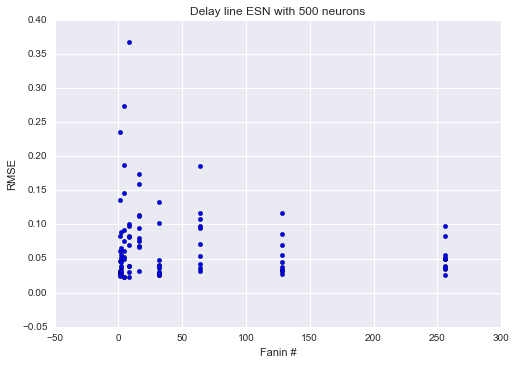

In [9]:
pylab.figure()
pylab.title("Delay line ESN with 500 neurons")
pylab.scatter(fanins, rmses)
pylab.xlabel("Fanin #")
pylab.ylabel("RMSE")
pylab.show()

The first plot (echo state) uses non-spiking `Tanh` neurons, with a standard set of parameters that have also been tuned for this example. It does slightly better than the spiking Nengo reservoir (both structured and refined), but this should not be surprising since it uses rate neurons. We can also tune them to be the same by using `Tanh` rate units for Nengo as well.

The second plot (liquid state) uses spiking `LIF` neurons, and normalizes the recurrent gain by something like the average firing rate. This does fairly poorly compared to Nengo.

In [7]:
with nengolib.Network():
    esn = EchoState(n_neurons, 1, neuron_type=nengo.LIF(), include_bias=False,
                    recurrent_synapse=synapse, readout_synapse=synapse, gain=1.25/250,
                    ens_seed=0, rng=rng)
    train_and_test(esn, reg=0.1, subtitle="Liquid State Machine")